# Logistic regression classifier model on Amazon Fine foods reviews dataset.


#### * Our objective here is to build a Logistic regression model to estimate the polarity of a review as Positive/Negative based on the words used in the review.

 * We are given a 500K datset of reviews from Amazon customers regarding the various food products.

 * We will be using 5 types of Vectorizations to convert text reviews into vectors and we will conclude towards the best Vectorizer based on several performance metrics.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [5]:
con=sqlite3.connect('G:\ML\Data_Sets\Amazon\Cleaned_AmazonDB.sqlite')

In [6]:
data=pd.read_sql_query('''Select * from Reviews''',con)
data.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak watch realli rosi movi incorp...
2,2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [10]:
data.shape

(364171, 13)

## Time based sorting of data:

In [7]:
sorted_data=data.sort_values('Time',axis=0,ascending=True)

In [8]:
sorted_data.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year child sister ...
424,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur star michael keaton...
423,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## Splitting of Test and Train data

In [8]:
train_length=round(0.7*len(data))
print(train_length)
test_length=round(0.3*len(data))
print(test_length)
print((train_length+test_length)==len(data))

254920
109251
True


In [9]:
train=sorted_data.head(train_length)
test=sorted_data.tail(test_length)

## Grid Search CV

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [11]:
def grid_s(x,regulariser,list1=[10**-4, 10**-2, 10**0, 10**2]):
    '''
    Program to return optimal values for Hyper Parameter C=(1/Lambda).
    '''
    ts=TimeSeriesSplit(n_splits=10)
    par=[{'C': list1}]
    lr= LogisticRegression(penalty=regulariser,max_iter=200,random_state=33)
    grid=GridSearchCV(lr,par,cv=ts.split(x),scoring='accuracy',verbose=2)
    return grid

## Randomized Search CV

In [92]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [193]:
def random_s(x,regulariser):
    '''
    To tune Hyper paramater using Randomized Search CV
    '''
    ts=TimeSeriesSplit(n_splits=10)
    #un=list(uniform.rvs(loc=10**-2,scale=10**4))
    par={'C': [uniform.rvs(loc=10**-2,scale=10**2)]}
    lr= LogisticRegression(penalty=regulariser,random_state=33,class_weight='balanced')
    rand=GridSearchCV(lr,par,cv=ts.split(x),scoring='accuracy',verbose=2)
    return rand

## L1 Analyser function:

In [14]:
def l1_analyser(x,y,list1=[100,10,1,0.1,0.01]):
    '''
    to analyse sparsity and effects of L1 regulariser for different values of Lambda
    '''
    for value in list1:
        model=LogisticRegression(C=value,penalty='l1')
        lamda=1/value
        model.fit(x,y)
        w=model.coef_    
        print('\n*************************************************************************************************************')
        print(f'\n lambda = {lamda}')
        print(f'\n Number of non zero elements = {np.count_nonzero(w)}')
        print(f'\n Sparisty = {np.mean((model.coef_.ravel()) == 0)*100}')        
        p=model.predict(x)
        error=1-(accuracy_score(p,y))
        print(f'\n Error = {error}')
        score=model.score(x,y)
        print(f'\n Score = {score}')
    
    


## MultiCollinearity check:

In [15]:
from scipy import spatial
def isMultiColinear(weight,new_weight,length):
    '''
    To check Multi colinearity
    '''
    count=0
    d=spatial.distance.euclidean(weight,new_weight)
    print(f'\n The Euclidean distance between weight vectors after perturbation is {d}')
    cos_d=spatial.distance.cosine(weight,new_weight)
    print(f'\n The Cosine similarity between weight vectors after perturbation is {cos_d}')
        
    for i in range(0,length-1):  
        x=(abs(weight[:,i]-new_weight[:,i]))/weight[:,i]
        if(x >= 0.2):
            #print(f'\n The feature {i+1} varies by more than 20% after the perturbation ')
            count+=1
    if(count!=0):
        print(f'\n {count} number of features out of {length} are multicollinear as they vary by more than 20% after perturbation')

## Confusion Matrix & Performance Analyser:

In [10]:
def CM(x,y):
    '''
    Function to plot confusion matrix
    '''
    CM_Matrix=confusion_matrix(x,y)
    tn,fn,fp,tp=CM_Matrix.ravel()
    print('\n ******************************************************************************* \n')
    
    print(f"TNR value is {tn/(tn+fn)}")
    print(f"FNR value is {fn/(tn+fn)}")
    print(f"FPR value is {fp/(tp+fp)}")
    print(f"TPR value is {tp/(tp+fp)}")
    
    print('\n ******************************************************************************* \n')
    print('Confusion Matrix is :')
    print(CM_Matrix)
    
    print('\n ******************************************************************************* \n')
    precision= tp/(tp+fp)
    print(f'Precision is {precision}')
    recall=tp/(tp+fn)
    print(f'Recall value is {recall}')
    f1=2*((precision*recall)/(precision+recall))
    print(f'F1 Score is {f1}')
    
    print('\n ******************************************************************************* \n')
    print('Heat Map of the Confusion matrix is')
    tmp=pd.DataFrame(CM_Matrix)
    ann=np.array([['True Negative = '+str(tn),'False negative = '+str(fn)],['False Positive = '+str(fp),'True Positive = '+str(tp)]])
    sns.heatmap(tmp,annot=ann,fmt='')
    plt.title('Confusion Matrix : ')
    
    print('\n ******************************************************************************* \n')
    
    

# 1.) Bag Of Words Vectorization:

In [11]:
BOW=CountVectorizer(dtype='float')
BOW.fit(train['New'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='float', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=1, ngram_range=(1, 1),
        preprocessor=None, stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [12]:
BOW_train= BOW.transform(train['New'])
BOW_test=BOW.transform(test['New'])

In [19]:
BOW_train.shape

(254920, 55207)

In [13]:
scaler=StandardScaler(with_mean=False)
std_BOW_train=scaler.fit_transform(BOW_train)
std_BOW_test=scaler.transform(BOW_test)

### L2 Regularisation :

In [21]:
BOW_grid=grid_s(std_BOW_train,'l2')

In [22]:
BOW_grid.fit(std_BOW_train,train['Score'])

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 51.4min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000024975F72518>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000], 'penalty': ['l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [23]:
BOW_grid.best_estimator_

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [24]:
BOW_grid.best_score_

0.9015793561750237

In [134]:
#Random Search
BOW_rand=random_s(std_BOW_train,'l2')

In [135]:
BOW_rand.fit(std_BOW_train,train['Score'])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=13.863529268277464 ............................................
[CV] ............................. C=13.863529268277464, total=  11.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV] C=13.863529268277464 ............................................
[CV] ............................. C=13.863529268277464, total=  29.0s
[CV] C=13.863529268277464 ............................................
[CV] ............................. C=13.863529268277464, total= 1.5min
[CV] C=13.863529268277464 ............................................
[CV] ............................. C=13.863529268277464, total= 1.7min
[CV] C=13.863529268277464 ............................................
[CV] ............................. C=13.863529268277464, total= 2.7min
[CV] C=13.863529268277464 ............................................
[CV] ............................. C=13.863529268277464, total= 3.3min
[CV] C=13.863529268277464 ............................................
[CV] ............................. C=13.863529268277464, total= 3.1min
[CV] C=13.863529268277464 ............................................
[CV] ............................. C=13.863529268277464, total= 2.5min
[CV] C

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.6min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026A416E45C8>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [13.863529268277464]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [136]:
BOW_rand.best_estimator_

LogisticRegression(C=13.863529268277464, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [137]:
BOW_rand.best_score_

0.8782558039181841

In [138]:
LR1=LogisticRegression(C=13.863529268277464, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [139]:
LR1.fit(std_BOW_train,train['Score'])

LogisticRegression(C=13.863529268277464, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [140]:
pred=LR1.predict(std_BOW_test)

In [141]:
acc=accuracy_score(pred,test['Score'])
print(acc*100)

86.00378943899827


### L1 Regularisation :

In [15]:
list1=[10**-1,1,10,100,500]
BOW_grid=grid_s(BOW_train[:100000],'l1')


In [16]:
BOW_grid.fit(BOW_train[:100000],train['Score'][:100000])

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] C=0.0001 ........................................................
[CV] .............. C=0.0001, score=0.10374037403740374, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] C=0.0001 ........................................................
[CV] .............. C=0.0001, score=0.11265126512651265, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8916391639163916, total=   0.3s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8849284928492849, total=   0.4s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8722772277227723, total=   0.5s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8680968096809681, total=   0.6s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8741474147414742, total=   0.7s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8564356435643564, total=   0.9s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8671067106710671, total=   1.0s
[CV] C

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.8min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000016F30FF3830>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=3)

In [17]:
BOW_grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
BOW_grid.best_score_

0.9203190319031903

In [142]:
#Random Search
BOW_rand=random_s(BOW_train,'l1')

In [143]:
BOW_rand.fit(BOW_train,train['Score'])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=68.37288079050771 .............................................
[CV] .............................. C=68.37288079050771, total=   2.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] C=68.37288079050771 .............................................
[CV] .............................. C=68.37288079050771, total=   8.0s
[CV] C=68.37288079050771 .............................................
[CV] .............................. C=68.37288079050771, total=   6.4s
[CV] C=68.37288079050771 .............................................
[CV] .............................. C=68.37288079050771, total=   5.8s
[CV] C=68.37288079050771 .............................................
[CV] .............................. C=68.37288079050771, total=  12.8s
[CV] C=68.37288079050771 .............................................
[CV] .............................. C=68.37288079050771, total=   9.4s
[CV] C=68.37288079050771 .............................................
[CV] .............................. C=68.37288079050771, total=  13.7s
[CV] C=68.37288079050771 .............................................
[CV] .............................. C=68.37288079050771, total=  13.6s
[CV] C

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026A41B4B3B8>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [68.37288079050771]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [144]:
BOW_rand.best_estimator_

LogisticRegression(C=68.37288079050771, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [145]:
BOW_rand.best_score_

0.8910330542849746

In [146]:
LR1=LogisticRegression(C=68.37288079050771, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [147]:
LR1.fit(std_BOW_train,train['Score'])

LogisticRegression(C=68.37288079050771, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [148]:
pred1=LR1.predict(std_BOW_test)

In [149]:
acc=accuracy_score(pred1,test['Score'])
print(acc*100)

86.33788249077811


### Analysis of Sparsity and Error on L1 regulariser with increase in Lambda

Here we are going to analyse 55207 dimensional data with different values of Lambda and we are going to analyse how increase in hyperparameter impacts the model.

In [34]:
l1_analyser(std_BOW_train,train['Score'])


*************************************************************************************************************

 lambda = 0.01

 Number of non zero elements = 40702

 Sparisty = 26.273842085242816

 Error = 0.043197865997175566

 Score = 0.9568021340028244

*************************************************************************************************************

 lambda = 0.1

 Number of non zero elements = 55205

 Sparisty = 0.003622729001757024

 Error = 0.04872509022438409

 Score = 0.9512749097756159

*************************************************************************************************************

 lambda = 1.0

 Number of non zero elements = 54509

 Sparisty = 1.2643324216132013

 Error = 0.0447944453161776

 Score = 0.9552055546838224

*************************************************************************************************************

 lambda = 10.0

 Number of non zero elements = 26761

 Sparisty = 51.526074591990145

 Error = 0.04410403263769025

 Sco

##### Inference : As expected, the sparsity and error increases with increase in Lambda with reduction in train accuracy.


## Performace of Logistic regression model with BOW_unigram:

#### Performance with L2 regulariser


 ******************************************************************************* 

TNR value is 0.740632042345789
FNR value is 0.259367957654211
FPR value is 0.11469446600865033
TPR value is 0.8853055339913497

 ******************************************************************************* 

Confusion Matrix is :
[[14132  4949]
 [10342 79828]]

 ******************************************************************************* 

Precision is 0.8853055339913497
Recall value is 0.941623317645116
F1 Score is 0.912596386334147

 ******************************************************************************* 

Heat Map of the Confusion matrix is

 ******************************************************************************* 



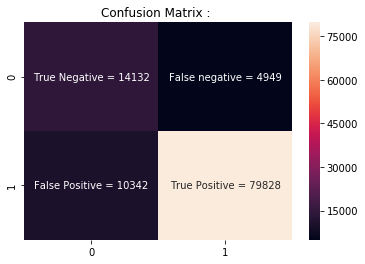

In [150]:
CM(test['Score'],pred)

#### Performance with L1 regulariser


 ******************************************************************************* 

TNR value is 0.7449295110319165
FNR value is 0.25507048896808343
FPR value is 0.11155594987246313
TPR value is 0.8884440501275369

 ******************************************************************************* 

Confusion Matrix is :
[[14214  4867]
 [10059 80111]]

 ******************************************************************************* 

Precision is 0.8884440501275369
Recall value is 0.9427263527030526
F1 Score is 0.9147806426564963

 ******************************************************************************* 

Heat Map of the Confusion matrix is

 ******************************************************************************* 



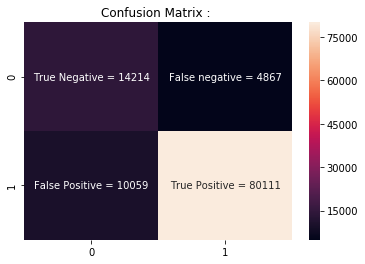

In [151]:
CM(test['Score'],pred1)

## Feature Importance:

In [24]:
weights= LR1.coef_
weights

array([[0.01068853, 0.10985958, 0.        , ..., 0.00480112, 0.01502263,
        0.00179289]])

In [115]:
# Checking Multicolinearity
new=BOW_train
BOW_train.data+=0.001

In [116]:
LR1.fit(BOW_train,train['Score'])

LogisticRegression(C=16.914235934301406, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [121]:
BOW_train=new
perturbated_weight=LR1.coef_
perturbated_weight

array([[0.        , 1.13265624, 0.        , ..., 0.        , 0.52035827,
        0.        ]])

In [122]:
length = weights.shape[1]

In [123]:
isMultiColinear(weights,perturbated_weight,length)


 The Euclidean distance between weight vectors after perturbation is 413.3607592416713

 The Cosine similarity between weight vectors after perturbation is 0.3647590350045299

 26555 number of features out of 55207 are multicollinear as they vary by more than 20% after perturbation


# 2.) BOW - Bi-gram Vectorization:

In [152]:
BOW1=CountVectorizer(ngram_range=(1,2),dtype='float')
BOW1.fit(train['New'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='float', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=1, ngram_range=(1, 2),
        preprocessor=None, stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [153]:
BOW1_train= BOW1.transform(train['New'])
BOW1_test=BOW1.transform(test['New'])

In [19]:
BOW1_train.shape

(254920, 2184164)

In [154]:
scaler=StandardScaler(with_mean=False)
std_BOW1_train=scaler.fit_transform(BOW1_train)
std_BOW1_test=scaler.transform(BOW1_test)

### L2 Regularisation :

In [20]:
BOW1_grid=grid_s(BOW1_train[:100000],'l2')

In [23]:
BOW1_grid.fit(BOW1_train[0:100000],train['Score'][:100000])

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 22.3min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000020CF8E3B938>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [24]:
BOW1_grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
BOW1_grid.best_score_

0.9275577557755775

In [157]:
#Random Search
BOW_rand=random_s(BOW1_train[:100000],'l2')

In [158]:
BOW_rand.fit(BOW1_train[:100000],train['Score'][:100000])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=58.72437676652644 .............................................
[CV] .............................. C=58.72437676652644, total=   8.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s


[CV] C=58.72437676652644 .............................................
[CV] .............................. C=58.72437676652644, total=  11.9s
[CV] C=58.72437676652644 .............................................
[CV] .............................. C=58.72437676652644, total=  14.9s
[CV] C=58.72437676652644 .............................................
[CV] .............................. C=58.72437676652644, total=  19.3s
[CV] C=58.72437676652644 .............................................
[CV] .............................. C=58.72437676652644, total=  22.1s
[CV] C=58.72437676652644 .............................................
[CV] .............................. C=58.72437676652644, total=  30.0s
[CV] C=58.72437676652644 .............................................
[CV] .............................. C=58.72437676652644, total=  45.9s
[CV] C=58.72437676652644 .............................................
[CV] .............................. C=58.72437676652644, total=  50.6s
[CV] C

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.2min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026A3DEC9EB8>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [58.72437676652644]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [159]:
BOW_rand.best_estimator_

LogisticRegression(C=58.72437676652644, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [160]:
BOW_rand.best_score_

0.9272167216721672

In [161]:
lr2= LogisticRegression(C=58.72437676652644, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [162]:
lr2.fit(std_BOW1_train,train['Score'])

LogisticRegression(C=58.72437676652644, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [163]:
pred=lr2.predict(std_BOW1_test)

In [164]:
acc=accuracy_score(pred,test['Score'])
print(acc*100)

88.81932430824432


### L1 Regularisation :

In [40]:
BOW1_grid1=grid_s(BOW1_train[:100000],'l1')

In [42]:
BOW1_grid1.fit(BOW1_train[:100000],train['Score'][:100000])

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.3min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001D7D045A518>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000], 'penalty': ['l1']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [44]:
BOW1_grid1.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
BOW1_grid1.best_score_

0.9237623762376238

In [165]:
#Random Search
BOW1_rand1=random_s(BOW1_train[:100000],'l1')

In [166]:
BOW1_rand1.fit(BOW1_train[:100000],train['Score'][:100000])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=11.972567953402924 ............................................
[CV] ............................. C=11.972567953402924, total=   8.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV] C=11.972567953402924 ............................................
[CV] ............................. C=11.972567953402924, total=  12.3s
[CV] C=11.972567953402924 ............................................
[CV] ............................. C=11.972567953402924, total=   8.5s
[CV] C=11.972567953402924 ............................................
[CV] ............................. C=11.972567953402924, total=  22.4s
[CV] C=11.972567953402924 ............................................
[CV] ............................. C=11.972567953402924, total=  30.2s
[CV] C=11.972567953402924 ............................................
[CV] ............................. C=11.972567953402924, total=  11.5s
[CV] C=11.972567953402924 ............................................
[CV] ............................. C=11.972567953402924, total=  10.7s
[CV] C=11.972567953402924 ............................................
[CV] ............................. C=11.972567953402924, total=  13.6s
[CV] C

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.2min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026A3DEC9A98>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [11.972567953402924]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [167]:
BOW1_rand1.best_estimator_

LogisticRegression(C=11.972567953402924, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [168]:
BOW1_rand1.best_score_

0.9190759075907591

In [169]:
LR2=LogisticRegression(C=11.972567953402924, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [170]:
LR2.fit(std_BOW1_train,train['Score'])

LogisticRegression(C=11.972567953402924, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [171]:
pred1=LR2.predict(std_BOW1_test)

In [172]:
acc=accuracy_score(pred1,test['Score'])
print(acc*100)

91.03623765457525


### Analysis of Sparsity and Error on L1 regulariser with increase in Lambda

Here we are going to analyse 2184164 dimensional data with different values of Lambda and we are going to analyse how increase in hyperparameter impacts the model.

In [21]:
list1=[100,75,50,25,10]
l1_analyser(std_BOW1_train,train['Score'],list1)


*************************************************************************************************************

 lambda = 0.01

 Number of non zero elements = 327603

 Sparisty = 85.00098893672819

 Error = 2.3536795857537207e-05

 Score = 0.9999764632041425

*************************************************************************************************************

 lambda = 0.013333333333333334

 Number of non zero elements = 193062

 Sparisty = 91.16082858246908

 Error = 2.3536795857537207e-05

 Score = 0.9999764632041425

*************************************************************************************************************

 lambda = 0.02

 Number of non zero elements = 230972

 Sparisty = 89.42515305627234

 Error = 2.3536795857537207e-05

 Score = 0.9999764632041425

*************************************************************************************************************

 lambda = 0.04

 Number of non zero elements = 205347

 Sparisty = 90.59837081830851

 Error = 

##### Inference : As expected, the sparsity and error increases with increase in Lambda with reduction in train accuracy.


## Feature Importance:

In [22]:
weights1= lr2.coef_
weights1

array([[ 0.00179506,  0.00179506,  0.0058284 , ..., -0.00010748,
         0.00054234,  0.00054234]])

In [23]:
# Calculating perturbated weight
new1=BOW1_train
BOW1_train.data+=0.001
lr2.fit(BOW1_train,train['Score'])
perturbated_weight1=lr2.coef_
BOW1_train=new1

In [25]:
isMultiColinear(weights1,perturbated_weight1,weights1.shape[1])


 The Euclidean distance between weight vectors after perturbation is 152.4399119865029

 The Cosine similarity between weight vectors after perturbation is 0.4827248450833779

 956765 number of features out of 2184164 are multicollinear as they vary by more than 20% after perturbation


## Performace of Logistic regression model with BOW_Bigram:

#### Performance with L2 regulariser


 ******************************************************************************* 

TNR value is 0.4801635134426917
FNR value is 0.5198364865573083
FPR value is 0.025463014306310303
TPR value is 0.9745369856936897

 ******************************************************************************* 

Confusion Matrix is :
[[ 9162  9919]
 [ 2296 87874]]

 ******************************************************************************* 

Precision is 0.9745369856936897
Recall value is 0.8985714723957747
F1 Score is 0.9350138059086097

 ******************************************************************************* 

Heat Map of the Confusion matrix is

 ******************************************************************************* 



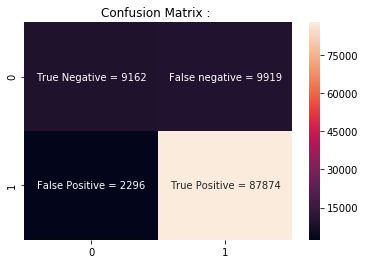

In [173]:
CM(test['Score'],pred)

#### Performance with L1 regulariser


 ******************************************************************************* 

TNR value is 0.6091923903359363
FNR value is 0.39080760966406375
FPR value is 0.02590662082732616
TPR value is 0.9740933791726738

 ******************************************************************************* 

Confusion Matrix is :
[[11624  7457]
 [ 2336 87834]]

 ******************************************************************************* 

Precision is 0.9740933791726738
Recall value is 0.9217449706687935
F1 Score is 0.9471964456139026

 ******************************************************************************* 

Heat Map of the Confusion matrix is

 ******************************************************************************* 



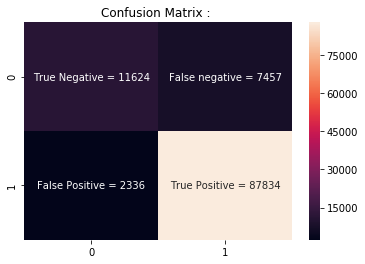

In [174]:
CM(test['Score'],pred1)

# 3.) TF-IDF Vectorization:

In [39]:
tfidf=TfidfVectorizer(dtype='float')
tfidf.fit(train['New'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='float', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=1, ngram_range=(1, 1),
        norm='l2', preprocessor=None, smooth_idf=True, stop_words=None,
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [40]:
tfidf_train= tfidf.transform(train['New'])
tfidf_test= tfidf.transform(test['New'])

In [24]:
tfidf_train.shape

(254920, 55207)

In [41]:
scaler=StandardScaler(with_mean=False)
std_tfidf_train=scaler.fit_transform(tfidf_train)
std_tfidf_test=scaler.transform(tfidf_test)

### L2 Regularisation :

In [26]:
t_grid=grid_s(tfidf_train,'l2')

In [27]:
t_grid.fit(tfidf_train,train['Score'])

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.5min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000210F4EAC938>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100], 'penalty': ['l2'], 'solver': ['saga'], 'max_iter': [200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [28]:
t_grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
t_grid.best_score_

0.9150556658323984

In [175]:
#Random Search
t_rand=random_s(tfidf_train,'l2')

In [176]:
t_rand.fit(tfidf_train,train['Score'])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=13.511474041595418 ............................................
[CV] ............................. C=13.511474041595418, total=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] C=13.511474041595418 ............................................
[CV] ............................. C=13.511474041595418, total=   2.5s
[CV] C=13.511474041595418 ............................................
[CV] ............................. C=13.511474041595418, total=   4.4s
[CV] C=13.511474041595418 ............................................
[CV] ............................. C=13.511474041595418, total=   6.0s
[CV] C=13.511474041595418 ............................................
[CV] ............................. C=13.511474041595418, total=   7.3s
[CV] C=13.511474041595418 ............................................
[CV] ............................. C=13.511474041595418, total=   9.6s
[CV] C=13.511474041595418 ............................................
[CV] ............................. C=13.511474041595418, total=  12.3s
[CV] C=13.511474041595418 ............................................
[CV] ............................. C=13.511474041595418, total=  17.5s
[CV] C

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026A76A64A40>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [13.511474041595418]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [177]:
t_rand.best_estimator_

LogisticRegression(C=13.511474041595418, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [178]:
t_rand.best_score_

0.9170190730991629

In [179]:
lr3= LogisticRegression(C=13.511474041595418, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)


In [180]:
lr3.fit(std_tfidf_train,train['Score'])

LogisticRegression(C=13.511474041595418, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [181]:
pred=lr3.predict(std_tfidf_test)

In [182]:
acc=accuracy_score(pred,test['Score'])
print(acc*100)

87.71635957565606


### L1 Regularisation :

In [18]:
c_list=[10**-2,0.1,1,50,100,500]
t1_grid=grid_s(std_tfidf_train,'l1',c_list)

In [19]:
t1_grid.fit(std_tfidf_train,train['Score'])

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   1.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   2.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   3.6s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   4.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   5.5s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   7.4s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   9.0s
[CV] C

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 164.1min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000012DE6172D00>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 50, 100, 500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [20]:
t1_grid.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
t1_grid.best_score_

0.9135410373694658

In [183]:
#Random Search
t1_rand=random_s(std_tfidf_train,'l1')

In [184]:
t1_rand.fit(std_tfidf_train,train['Score'])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=94.33865662517721 .............................................
[CV] .............................. C=94.33865662517721, total=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] C=94.33865662517721 .............................................
[CV] .............................. C=94.33865662517721, total=18.3min
[CV] C=94.33865662517721 .............................................
[CV] .............................. C=94.33865662517721, total=   9.2s
[CV] C=94.33865662517721 .............................................
[CV] .............................. C=94.33865662517721, total=  10.7s
[CV] C=94.33865662517721 .............................................
[CV] .............................. C=94.33865662517721, total=   9.9s
[CV] C=94.33865662517721 .............................................
[CV] .............................. C=94.33865662517721, total=  14.4s
[CV] C=94.33865662517721 .............................................
[CV] .............................. C=94.33865662517721, total=  16.8s
[CV] C=94.33865662517721 .............................................
[CV] .............................. C=94.33865662517721, total=  16.8s
[CV] C

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 20.5min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026A7D5F2AF0>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [94.33865662517721]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [185]:
t1_rand.best_estimator_

LogisticRegression(C=94.33865662517721, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [186]:
t1_rand.best_score_

0.8743591956502977

In [46]:
lr3= LogisticRegression(C=74.35612570253635, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [47]:
lr3.fit(std_tfidf_train,train['Score'])

LogisticRegression(C=74.35612570253635, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [48]:
pred1=lr3.predict(std_tfidf_test)

In [49]:
acc=accuracy_score(pred1,test['Score'])
print(acc*100)

85.80241828450083


### Analysis of Sparsity and Error on L1 regulariser with increase in Lambda

Here we are going to analyse 55207 dimensional data with different values of Lambda and we are going to analyse how increase in hyperparameter impacts the model.

In [54]:
#list1=[100,70,40,10,1]
l1_analyser(std_tfidf_train,train['Score'])


*************************************************************************************************************

 lambda = 0.01

 Number of non zero elements = 45133

 Sparisty = 18.24768598185013

 Error = 0.043476384748156294

 Score = 0.9565236152518437

*************************************************************************************************************

 lambda = 0.1

 Number of non zero elements = 43614

 Sparisty = 20.99914865868459

 Error = 0.04348423034677551

 Score = 0.9565157696532245

*************************************************************************************************************

 lambda = 1.0

 Number of non zero elements = 39423

 Sparisty = 28.59057728186643

 Error = 0.04353914953710969

 Score = 0.9564608504628903

*************************************************************************************************************

 lambda = 10.0

 Number of non zero elements = 31287

 Sparisty = 43.327838861014

 Error = 0.043966734661854745

 Score = 0

##### Inference : As expected, the sparsity and error increases with increase in Lambda with reduction in train accuracy.


## Feature Importance:

In [23]:
weights= lr3.coef_
weights

array([[0.00197251, 0.00373522, 0.00072669, ..., 0.001307  , 0.00105661,
        0.00107435]])

In [24]:
# Calculating perturbated weight
new1=tfidf_train
tfidf_train.data+=0.0001
lr3.fit(tfidf_train,train['Score'])
perturbated_weight1=lr3.coef_
tfidf_train=new1

In [28]:
isMultiColinear(weights,perturbated_weight1,weights.shape[1])


 The Euclidean distance between weight vectors after perturbation is 438.31359332418043

 The Cosine similarity between weight vectors after perturbation is 0.44730307867071584

 41768 number of features out of 55207 are multicollinear as they vary by more than 20% after perturbation


## Performace of Logistic regression model with TF-IDF:

#### Performance with L2 regulariser


 ******************************************************************************* 

TNR value is 0.8232797023216812
FNR value is 0.17672029767831873
FPR value is 0.11145613840523455
TPR value is 0.8885438615947654

 ******************************************************************************* 

Confusion Matrix is :
[[15709  3372]
 [10050 80120]]

 ******************************************************************************* 

Precision is 0.8885438615947654
Recall value is 0.9596128970440282
F1 Score is 0.9227119346777073

 ******************************************************************************* 

Heat Map of the Confusion matrix is

 ******************************************************************************* 



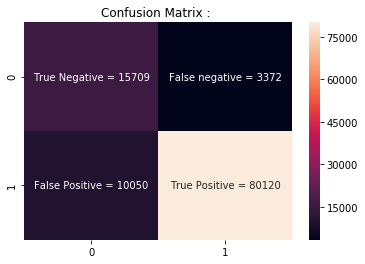

In [50]:
CM(test['Score'],pred)

#### Performance with L1 regulariser


 ******************************************************************************* 

TNR value is 0.7390597977045228
FNR value is 0.26094020229547715
FPR value is 0.11680159698347566
TPR value is 0.8831984030165243

 ******************************************************************************* 

Confusion Matrix is :
[[14102  4979]
 [10532 79638]]

 ******************************************************************************* 

Precision is 0.8831984030165243
Recall value is 0.9411583960669841
F1 Score is 0.9112577022318592

 ******************************************************************************* 

Heat Map of the Confusion matrix is

 ******************************************************************************* 



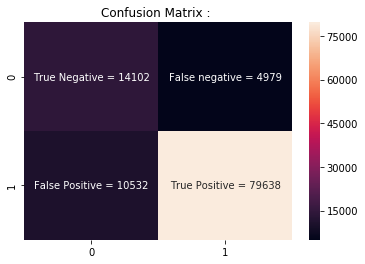

In [51]:
CM(test['Score'],pred1)

# Building W2V Model:

In [52]:
from gensim.models import Word2Vec

In [53]:
#Creating sentence list

sentence_list=[]
for sentence in train['New']:
    sentence_list.append(sentence.split())

sentence_list[5]


['one', 'movi', 'movi', 'collect', 'fill', 'whatev', 'els', 'want', 'call']

In [54]:
w2v=Word2Vec(sentence_list,size=50,min_count=1,workers=4)

In [55]:
w2v_list=list(w2v.wv.vocab)

In [18]:
len(w2v_list)

55208

# 4.) Average W2V Vectorization:

In [19]:
def avgwv(x):
    '''
    To calculate average word 2 vector model
    '''
    sent_vect=[]
    for sentence in x:
        count=0;
        s_v=np.zeros(50)
        for words in sentence.split():
            if words in w2v_list:
                V=w2v.wv[words]
                count+=1
                s_v+=V
            if (count!=0):
                s_v/=count
        sent_vect.append(s_v)
    return(sent_vect)
                    

In [17]:
train_w2v=avgwv(train['New'])

In [111]:
test_w2v=avgwv(test['New'])

In [56]:
import pickle

In [20]:
with open(r'G:\ML\Pickles\NB_Avgw2v.pickle','wb') as f:
    pickle.dump([train_w2v,test_w2v],f)

In [57]:
with open(r'G:\ML\Pickles\NB_Avgw2v.pickle','rb') as f:
    train_w2v,test_w2v=pickle.load(f)

In [58]:
scaler=StandardScaler(with_mean=False)
std_train_avgw2v=scaler.fit_transform(train_w2v)
std_test_avgw2v=scaler.transform(test_w2v)

### L2 Regularisation :

In [24]:
avg1_grid=grid_s(std_train_avgw2v,'l2')

In [25]:
avg1_grid.fit(std_train_avgw2v,train['Score'])

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.9min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000148968D2A40>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100], 'penalty': ['l2'], 'solver': ['saga'], 'max_iter': [200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [26]:
avg1_grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
avg1_grid.best_score_

0.8484940018986795

In [194]:
#Random Search
avg1_rand=random_s(std_train_avgw2v,'l2')

In [195]:
avg1_rand.fit(std_train_avgw2v,train['Score'])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=30.977789763829968 ............................................
[CV] ............................. C=30.977789763829968, total=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] C=30.977789763829968 ............................................
[CV] ............................. C=30.977789763829968, total=   1.6s
[CV] C=30.977789763829968 ............................................
[CV] ............................. C=30.977789763829968, total=   2.3s
[CV] C=30.977789763829968 ............................................
[CV] ............................. C=30.977789763829968, total=   2.8s
[CV] C=30.977789763829968 ............................................
[CV] ............................. C=30.977789763829968, total=   4.2s
[CV] C=30.977789763829968 ............................................
[CV] ............................. C=30.977789763829968, total=   6.4s
[CV] C=30.977789763829968 ............................................
[CV] ............................. C=30.977789763829968, total=   7.3s
[CV] C=30.977789763829968 ............................................
[CV] ............................. C=30.977789763829968, total=   7.0s
[CV] C

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026A7D683780>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [30.977789763829968]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [202]:
avg1_rand.best_estimator_

LogisticRegression(C=30.977789763829968, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [203]:
avg1_rand.best_score_

0.564067489427807

In [204]:
LR1=LogisticRegression(C=30.977789763829968, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [205]:
LR1.fit(std_train_avgw2v,train['Score'])

LogisticRegression(C=30.977789763829968, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [206]:
pred=LR1.predict(std_test_avgw2v)

In [207]:
acc=accuracy_score(pred,test['Score'])
print(acc*100)

55.98118095028879


### L1 Regularisation :

In [36]:
avg1_grid=grid_s(std_train_avgw2v,'l1')

In [37]:
avg1_grid.fit(std_train_avgw2v,train['Score'])

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000148968D27D8>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100], 'penalty': ['l1'], 'solver': ['saga'], 'max_iter': [200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [38]:
avg1_grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
avg1_grid.best_score_

0.8484983170794856

In [213]:
#Random Search
avg1_rand=random_s(std_train_avgw2v,'l1')

In [214]:
avg1_rand.fit(std_train_avgw2v,train['Score'])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=77.2320661773736 ..............................................
[CV] ............................... C=77.2320661773736, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] C=77.2320661773736 ..............................................
[CV] ............................... C=77.2320661773736, total=   1.5s
[CV] C=77.2320661773736 ..............................................
[CV] ............................... C=77.2320661773736, total=   2.3s
[CV] C=77.2320661773736 ..............................................
[CV] ............................... C=77.2320661773736, total=   3.2s
[CV] C=77.2320661773736 ..............................................
[CV] ............................... C=77.2320661773736, total=   4.1s
[CV] C=77.2320661773736 ..............................................
[CV] ............................... C=77.2320661773736, total=   5.1s
[CV] C=77.2320661773736 ..............................................
[CV] ............................... C=77.2320661773736, total=   6.1s
[CV] C=77.2320661773736 ..............................................
[CV] ............................... C=77.2320661773736, total=   7.6s
[CV] C

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026A35EA9990>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [77.2320661773736]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [215]:
avg1_rand.best_estimator_

LogisticRegression(C=77.2320661773736, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [216]:
avg1_rand.best_score_

0.5640761197894192

In [217]:
LR1=LogisticRegression(C=77.2320661773736, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [218]:
LR1.fit(std_train_avgw2v,train['Score'])

LogisticRegression(C=77.2320661773736, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [219]:
pred1=LR1.predict(std_test_avgw2v)

In [220]:
acc=accuracy_score(pred1,test['Score'])
print(acc*100)

82.87704460371073


### Analysis of Sparsity and Error on L1 regulariser with increase in Lambda

Here we are going to analyse 50 dimensional data with different values of Lambda and we are going to analyse how increase in hyperparameter impacts the model.

In [55]:
#list1=[100,70,40,10,1]
l1_analyser(std_train_avgw2v,train['Score'])


*************************************************************************************************************

 lambda = 0.01

 Number of non zero elements = 50

 Sparisty = 0.0

 Error = 0.14779930958732146

 Score = 0.8522006904126785

*************************************************************************************************************

 lambda = 0.1

 Number of non zero elements = 50

 Sparisty = 0.0

 Error = 0.14779538678801196

 Score = 0.852204613211988

*************************************************************************************************************

 lambda = 1.0

 Number of non zero elements = 50

 Sparisty = 0.0

 Error = 0.14778361839008314

 Score = 0.8522163816099169

*************************************************************************************************************

 lambda = 10.0

 Number of non zero elements = 49

 Sparisty = 2.0

 Error = 0.14777969559077353

 Score = 0.8522203044092265

**************************************************

## Performace of Logistic regression model with Avg W2V:

#### Performance with L2 regulariser


 ******************************************************************************* 

TNR value is 0.7396886955610293
FNR value is 0.2603113044389707
FPR value is 0.4782521903071975
TPR value is 0.5217478096928024

 ******************************************************************************* 

Confusion Matrix is :
[[14114  4967]
 [43124 47046]]

 ******************************************************************************* 

Precision is 0.5217478096928024
Recall value is 0.9045046430700018
F1 Score is 0.6617668778967949

 ******************************************************************************* 

Heat Map of the Confusion matrix is

 ******************************************************************************* 



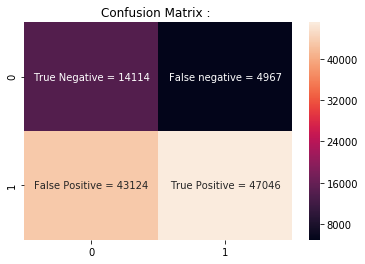

In [112]:
CM(test['Score'],pred)

#### Performance with L1 regulariser


 ******************************************************************************* 

TNR value is 0.039672973114616636
FNR value is 0.9603270268853834
FPR value is 0.004247532438726849
TPR value is 0.9957524675612731

 ******************************************************************************* 

Confusion Matrix is :
[[  757 18324]
 [  383 89787]]

 ******************************************************************************* 

Precision is 0.9957524675612731
Recall value is 0.8305075339234675
F1 Score is 0.9056540969634004

 ******************************************************************************* 

Heat Map of the Confusion matrix is

 ******************************************************************************* 



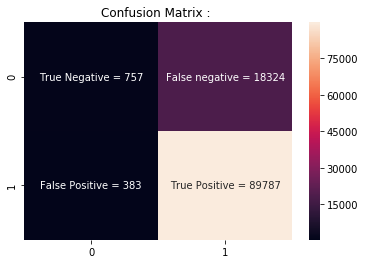

In [221]:
CM(test['Score'],pred1)

# 5.) Tf-IDF weighted Word2Vec Vectorization:

In [74]:
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [75]:
features=tfidf.get_feature_names()

def tfidf_w2v(x):
    '''
    To calculate Tf-IDf weighted word2vec for a review
    '''     
    row=0
    sentence_vectors=[]
    for sentences in x:
        weight=0
        s_v=np.zeros(50)
        for words in sentences.split():
            if words in w2v_list:
                try:
                    v=w2v.wv[words]
                    #tfidf_value=y[row,features.index(words)]
                    tfidf_value = dictionary[words]*sentences.count(words)
                    s_v+=(v*tfidf_value)
                    weight+=tfidf_value
                except(KeyError):
                    continue                
            else:
                continue
        if(weight!=0):
            s_v/=weight
        sentence_vectors.append(s_v)
        row+=1
    return sentence_vectors
                
    
    

In [40]:
train_tfidf_w2v=tfidf_w2v(train['New'])

In [43]:
with open(r'G:\ML\Pickles\tfidfw2v_train.pickle','wb') as f:
    pickle.dump(train_tfidf_w2v,f)

In [70]:
with open(r'G:\ML\Pickles\tfidfw2v_train.pickle','rb') as f:
    train_tfidf_w2v=pickle.load(f)

In [76]:
test_tfidf_w2v=tfidf_w2v(test['New'])

In [77]:
with open(r'G:\ML\Pickles\tfidfw2v_test.pickle','wb') as f:
    pickle.dump(test_tfidf_w2v,f)

In [78]:
with open(r'G:\ML\Pickles\tfidfw2v_test.pickle','rb') as f:
    test_tfidf_w2v=pickle.load(f)

In [80]:
scaler=StandardScaler(with_mean=False)
std_train_tfidfw2v=scaler.fit_transform(train_tfidf_w2v)
std_test_tfidfw2v=scaler.transform(test_tfidf_w2v)

### L2 Regulariser:

In [47]:
tfidf_w2v_grid=grid_s(std_train_tfidfw2v,'l2')

In [48]:
tfidf_w2v_grid.fit(std_train_tfidfw2v,train['Score'])

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.8s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   1.3s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   1.6s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   2.3s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   2.8s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   3.3s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   3.9s
[CV] C

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.6min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000023D12951830>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [49]:
tfidf_w2v_grid.best_score_

0.8822775524294468

In [50]:
tfidf_w2v_grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [114]:
#Random Search
tfidf_rand=random_s(std_train_tfidfw2v,'l2')

In [115]:
tfidf_rand.fit(std_train_tfidfw2v,train['Score'])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=31.3515259535785 ..............................................
[CV] ............................... C=31.3515259535785, total=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] C=31.3515259535785 ..............................................
[CV] ............................... C=31.3515259535785, total=   1.4s
[CV] C=31.3515259535785 ..............................................
[CV] ............................... C=31.3515259535785, total=   2.6s
[CV] C=31.3515259535785 ..............................................
[CV] ............................... C=31.3515259535785, total=   3.8s
[CV] C=31.3515259535785 ..............................................
[CV] ............................... C=31.3515259535785, total=   4.9s
[CV] C=31.3515259535785 ..............................................
[CV] ............................... C=31.3515259535785, total=   6.0s
[CV] C=31.3515259535785 ..............................................
[CV] ............................... C=31.3515259535785, total=   6.2s
[CV] C=31.3515259535785 ..............................................
[CV] ............................... C=31.3515259535785, total=   7.0s
[CV] C

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026A3ED54A40>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [31.3515259535785]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [116]:
tfidf_rand.best_estimator_

LogisticRegression(C=31.3515259535785, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [117]:
tfidf_rand.best_score_

0.8822430309829982

In [118]:
tfidf_w2v_model=LogisticRegression(C=31.3515259535785, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [119]:
tfidf_w2v_model.fit(std_train_tfidfw2v,train['Score'])

LogisticRegression(C=31.3515259535785, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [120]:
pred=tfidf_w2v_model.predict(std_test_tfidfw2v)

In [121]:
tfidfw2v_acc=accuracy_score(pred,test['Score'])

In [122]:
print(tfidfw2v_acc*100)

55.52992649952861


### L1 Regulariser:

In [55]:
tfidf_w2v_grid=grid_s(std_train_tfidfw2v,'l1')

In [56]:
tfidf_w2v_grid.fit(std_train_tfidfw2v,train['Score'])

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.6s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   1.1s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   1.5s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   2.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   2.1s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   3.1s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   3.5s
[CV] C

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 19.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000023D12951780>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [57]:
tfidf_w2v_grid.best_score_

0.8822646068870286

In [58]:
tfidf_w2v_grid.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [123]:
#Random Search
tfidf_rand=random_s(std_train_tfidfw2v,'l1')

In [124]:
tfidf_rand.fit(std_train_tfidfw2v,train['Score'])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=71.25536743771521 .............................................
[CV] .............................. C=71.25536743771521, total=   7.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] C=71.25536743771521 .............................................
[CV] .............................. C=71.25536743771521, total=  11.7s
[CV] C=71.25536743771521 .............................................
[CV] .............................. C=71.25536743771521, total=  19.8s
[CV] C=71.25536743771521 .............................................
[CV] .............................. C=71.25536743771521, total=  24.5s
[CV] C=71.25536743771521 .............................................
[CV] .............................. C=71.25536743771521, total=  32.0s
[CV] C=71.25536743771521 .............................................
[CV] .............................. C=71.25536743771521, total=  56.0s
[CV] C=71.25536743771521 .............................................
[CV] .............................. C=71.25536743771521, total=  51.2s
[CV] C=71.25536743771521 .............................................
[CV] .............................. C=71.25536743771521, total= 1.0min
[CV] C

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026A3ED54888>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=33, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [71.25536743771521]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

In [125]:
tfidf_rand.best_estimator_

LogisticRegression(C=71.25536743771521, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [126]:
tfidf_rand.best_score_

0.8822646068870286

In [127]:
tfidf_w2v_model=LogisticRegression(C=71.25536743771521, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [128]:
tfidf_w2v_model.fit(std_train_tfidfw2v,train['Score'])

LogisticRegression(C=71.25536743771521, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [129]:
pred1=tfidf_w2v_model.predict(std_test_tfidfw2v)

In [130]:
tfidfw2v_acc=accuracy_score(pred1,test['Score'])

In [131]:
print(tfidfw2v_acc*100)

44.062754574328835


### Analysis of Sparsity and Error on L1 regulariser with increase in Lambda

Here we are going to analyse 50 dimensional data with different values of Lambda and we are going to analyse how increase in hyperparameter impacts the model.

In [63]:
#list1=[100,70,40,10,1]
l1_analyser(std_train_tfidfw2v,train['Score'])


*************************************************************************************************************

 lambda = 0.01

 Number of non zero elements = 50

 Sparisty = 0.0

 Error = 0.11369056959045976

 Score = 0.8863094304095402

*************************************************************************************************************

 lambda = 0.1

 Number of non zero elements = 50

 Sparisty = 0.0

 Error = 0.11368272399184054

 Score = 0.8863172760081595

*************************************************************************************************************

 lambda = 1.0

 Number of non zero elements = 50

 Sparisty = 0.0

 Error = 0.11366310999529261

 Score = 0.8863368900047074

*************************************************************************************************************

 lambda = 10.0

 Number of non zero elements = 49

 Sparisty = 2.0

 Error = 0.11374941158010354

 Score = 0.8862505884198965

*************************************************

## Performace of Logistic regression model with Tf-idf W2V:

#### Performance with L2 regulariser


 ******************************************************************************* 

TNR value is 0.5107698757926733
FNR value is 0.48923012420732664
FPR value is 0.4352778085837862
TPR value is 0.5647221914162138

 ******************************************************************************* 

Confusion Matrix is :
[[ 9746  9335]
 [39249 50921]]

 ******************************************************************************* 

Precision is 0.5647221914162138
Recall value is 0.845077668613914
F1 Score is 0.6770239187374523

 ******************************************************************************* 

Heat Map of the Confusion matrix is

 ******************************************************************************* 



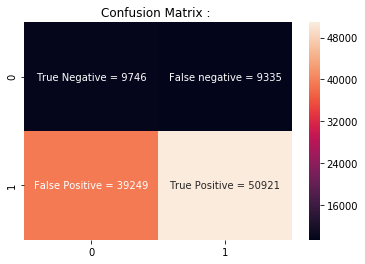

In [132]:
CM(test['Score'],pred)

#### Performance with L1 regulariser


 ******************************************************************************* 

TNR value is 0.6726586656883811
FNR value is 0.3273413343116189
FPR value is 0.6084728845514029
TPR value is 0.3915271154485971

 ******************************************************************************* 

Confusion Matrix is :
[[12835  6246]
 [54866 35304]]

 ******************************************************************************* 

Precision is 0.3915271154485971
Recall value is 0.8496750902527076
F1 Score is 0.5360461585180686

 ******************************************************************************* 

Heat Map of the Confusion matrix is

 ******************************************************************************* 



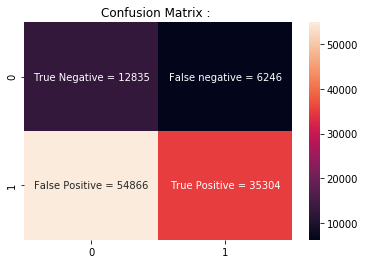

In [133]:
CM(test['Score'],pred1)

# Performace comparision between different vectorizations::

### Before Balancing Class weights : 

In [101]:
tmp=pd.DataFrame(columns=['Type of Vectorization','No. of Dimensions','Optimal_C-L2','Optimal_C-L1','Accuracy-L2','Accuracy-L1','F1 Score-L2','F1 Score-L1'])
tmp.loc[0]=['BOW_Unigram',55207,40.51,16.91,88.59,89.04,0.9315,0.9344]
tmp.loc[1]=['BOW_bigram',2184164,4.32,43.42,88.89,90.38,0.9355,0.9355]
tmp.loc[2]=['Tf-IDF',55207,35.82,74.35,89.36,88.68,0.9382,0.9454]
tmp.loc[3]=['Avg_W2v',50,24.70,43.031,82.87,82.87,0.9056,0.9056]
tmp.loc[4]=['Tf-IDF_W2v',50,11.23,2.19,87.16,87.15,0.9256,0.9256]


In [102]:
tmp

,Type of Vectorization,No. of Dimensions,Optimal_C-L2,Optimal_C-L1,Accuracy-L2,Accuracy-L1,F1 Score-L2,F1 Score-L1
0,BOW_Unigram,55207,40.51,16.910,88.59,89.04,0.9315,0.9344
1,BOW_bigram,2184164,4.32,43.420,88.89,90.38,0.9355,0.9355
2,Tf-IDF,55207,35.82,74.350,89.36,88.68,0.9382,0.9454
3,Avg_W2v,50,24.70,43.031,82.87,82.87,0.9056,0.9056
4,Tf-IDF_W2v,50,11.23,2.190,87.16,87.15,0.9256,0.9256


### After balancing class weights

In [222]:
tmp=pd.DataFrame(columns=['Type of Vectorization','No. of Dimensions','Optimal_C-L2','Optimal_C-L1','Accuracy-L2','Accuracy-L1','F1 Score-L2','F1 Score-L1'])
tmp.loc[0]=['BOW_Unigram',55207,13.86,68.37,86.00,86.33,0.9125,0.9147]
tmp.loc[1]=['BOW_bigram',2184164,58.72,11.07,88.81,91.03,0.9350,0.9471]
tmp.loc[2]=['Tf-IDF',55207,13.51,75.35,87.71,85.80,0.9112,0.9227]
tmp.loc[3]=['Avg_W2v',50,30.97,77.23,55.98,82.87,0.6617,0.9056]
tmp.loc[4]=['Tf-IDF_W2v',50,31.32,71.25,55.52,44.06,0.6770,0.5360]

In [223]:
tmp

,Type of Vectorization,No. of Dimensions,Optimal_C-L2,Optimal_C-L1,Accuracy-L2,Accuracy-L1,F1 Score-L2,F1 Score-L1
0,BOW_Unigram,55207,13.86,68.37,86.00,86.33,0.9125,0.9147
1,BOW_bigram,2184164,58.72,11.07,88.81,91.03,0.9350,0.9471
2,Tf-IDF,55207,13.51,75.35,87.71,85.80,0.9112,0.9227
3,Avg_W2v,50,30.97,77.23,55.98,82.87,0.6617,0.9056
4,Tf-IDF_W2v,50,31.32,71.25,55.52,44.06,0.6770,0.5360


# Conclusion from above exercise:

1.) The accuracy is high in BOW_Bigram with L1 regulariser and F1 score is high in TfIdf vectorizations with L1 regulariser.

2.) Average word2vec and TfIdf weighted word2vec, since they have only 50D vector for each text,their accuracy is on the much lower side than the counterparts.

3.) The features here are multicollinear and so we can't use our weight vector to interpret the Feature importance and we need to employ, Forward feature selection methods in order to do it.

4.)L1 regularisation is analyser for all type of Vectroizations for various alpha values and it is clear that as alpha increases, sparsity increases and train score decreases.

5.) After balancing the dataset, accuracy decreases for everything except BOW_Bigram, where Accuracy and F1 Score are improved.

6.) Word2vec models perform too poor after balancing the dataset, acuracy is too lower for 'TF-IDF- Word2vec with L1 regulariser'. 

*****************************************************************************************************************************

#### From above exercise I suggest that "TF IDF with L1 regulariser " can be used as it is highest on F1 score comparision with others and also each data here occupies 1/5th of the dimension taken for BOW_Bigram .

#### After balancing the datset, BOW_Bigram with L1 regulariser is working best, with highest accuracy and F1 score of 0.947.

